# "In mathematics, parametric curve fitting is the process of constructing a curve, or mathematical function, that has the best fit to a series of data points, possibly subject to constraints."

In [22]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

In [23]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")


In [24]:
## group by country, sum and transpose
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Italy"].values, columns=["total"])
## create new cases column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

dtf.head()

,total,new
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


In [4]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 1500*x

y_linear = f(x=np.arange(len(dtf)))
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.18**x

y_exponential = f(x=np.arange(len(dtf)))
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

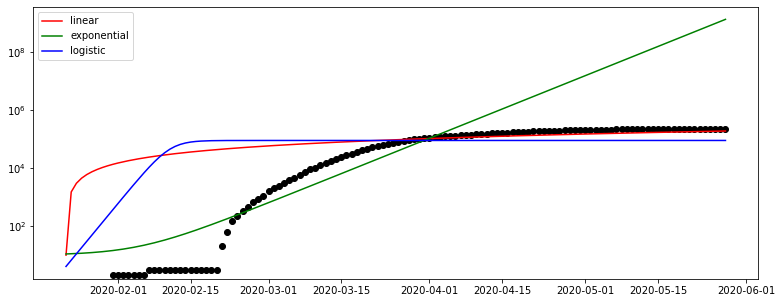

In [5]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.set_yscale('log')
ax.legend()
plt.show()

In [6]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 6000 * np.exp(-0.5 * ((x-60)/6)**2)

y_gaussian = f(x=np.arange(len(dtf)))

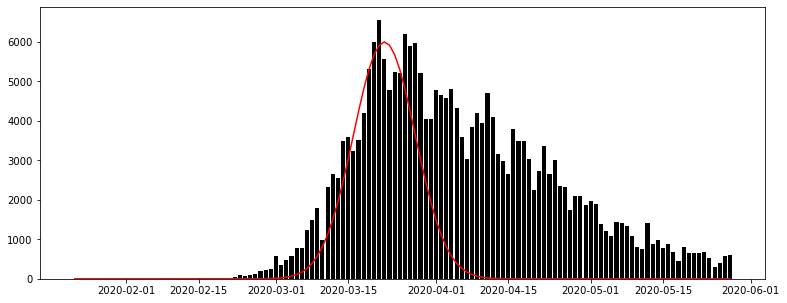

In [7]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

In [10]:
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y
## optimize from scipy
logistic_model, cov = optimize.curve_fit(logistic_f,
                                xdata=np.arange(len(dtf["total"])), 
                                ydata=dtf["total"].values, 
                                maxfev=10000,
                                p0=[np.max(dtf["total"]), 1, 1])
## print the parameters
logistic_model

array([2.25354818e+05, 9.57687360e-02, 7.19564167e+01])

In [13]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y
## optimize from scipy
gaussian_model, cov = optimize.curve_fit(gaussian_f,
                                xdata=np.arange(len(dtf["new"])), 
                                ydata=dtf["new"].values, 
                                maxfev=20000,
                                p0=[1, np.mean(dtf["new"]), 1])
## print the parameters
gaussian_model

array([1.00000000e+00, 1.81040625e+03, 1.00000000e+00])

In [14]:
'''
Plot parametric fitting.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [47]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(start,ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start=start,periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

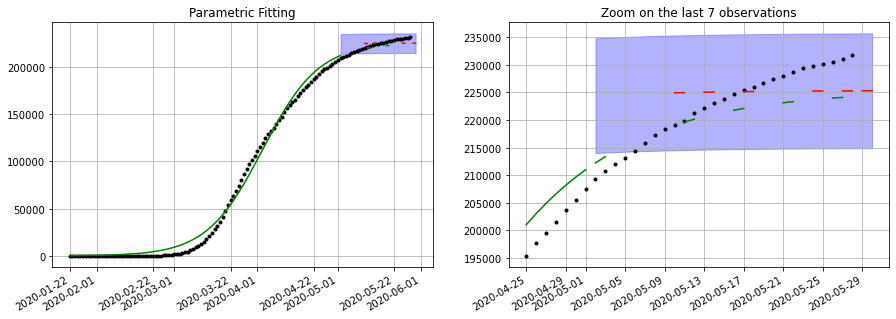

In [48]:
start='2020-05-01'
preds = forecast_curve(start,dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="D", zoom=7)

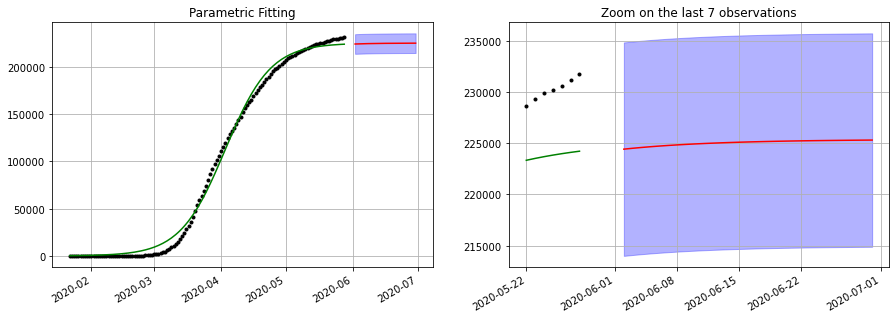

In [50]:
start='2020-06-01'
preds = forecast_curve(start,dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="D", zoom=7)

### O modelo previa que o número de casos seria menor para os últimos dias, do que o numero de casos reais.

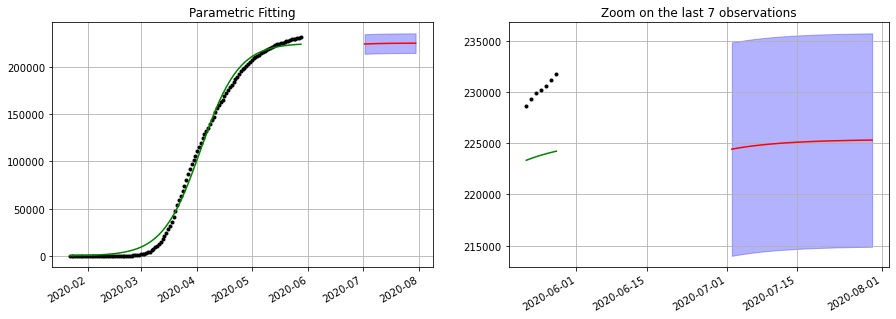

In [51]:
start='2020-07-01'
preds = forecast_curve(start,dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="D", zoom=7)